In [2]:
import os, sys
import numpy as np
import torch
import matplotlib.pyplot as plt

In [3]:
d = os.getcwd()
p = os.path.dirname(d)

sys.path.append(p)

In [4]:
from src.dynamics import RobotWorld
from src.lqr import Lqr
from src.algorithms.dpgpd import Dpgpd
from src.algorithms.adpgpd import ADpgpd
from src.algorithms.addpgpd_sampled import ADpgpdSampled
from src.algorithms.nnpgpd import Nnpgpd
from src.sampling import Sampler

In [41]:
ds = 4
da = 2

eta = 0.01
tau = 0.2
gamma = 0.9
alpha = 1.0

epochs = 2_000
n_pe = 100
n_rho = 100_000

b = - 100

G1 = - torch.tensor([
    [1.0, 0, 0, 0],
    [0, 1.0, 0, 0],
    [0, 0, .1, 0],
    [0, 0, 0, .1]
])

R1 =  - torch.tensor([
    [1., 0],
    [0, 1.],
]).double() * (tau / 2)

G2 = - torch.tensor([
    [.1, 0, 0, 0],
    [0, .1, 0, 0],
    [0, 0, 1.0, 0],
    [0, 0, 0, 1.0]
])

R2 = - torch.tensor([
    [1., 0],
    [0, 1.],
]).double() * (tau / 2)

env = RobotWorld(range_pos=[-10., 10.], range_vel=[-.1, .1])
lqr = Lqr(env.A, env.B, gamma)
sampler = Sampler(env, gamma)

In [5]:
# Optimal
P = lqr.calculate_optimal_P(G1, R1)
K = lqr.calculate_optimal_K(R1, P)
opt_lqr = sampler.estimate_V_rho_closed(P, 1_000_000)
opt_lqr

-569.5674147110157

In [6]:
# DPGPD
dpgpd = Dpgpd(env, eta, tau, gamma, b, G1, G2, R1, R2)
_, _, pl_exact, dl_exact = dpgpd.train_constrained(epochs, n_rho)

In [7]:
# ADPGPD
adpgpd = ADpgpd(env, eta, tau, gamma, b, alpha, G1, G2, R1, R2)
_, _, pl_approx, dl_approx = adpgpd.train_constrained(epochs, n_pe, n_rho)

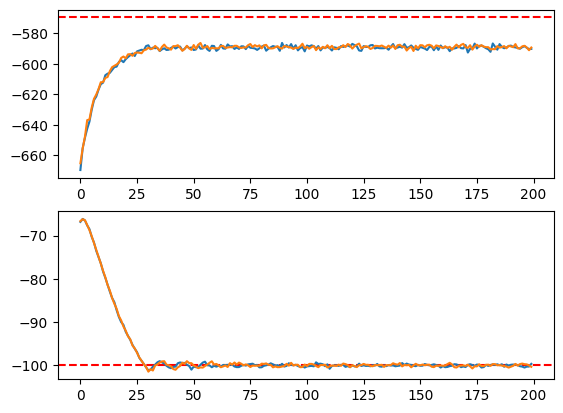

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=1)
axes = axes.flatten()

axes[0].axhline(y=opt_lqr, color='r', linestyle='--')
axes[0].plot(pl_exact)
axes[0].plot(pl_approx)

axes[1].axhline(y=b, color='r', linestyle='--')
axes[1].plot(dl_exact)
axes[1].plot(dl_approx)

plt.show()

In [9]:
np.save('../results/vel_primal_exact.npy', pl_exact)
np.save('../results/vel_dual_exact.npy', dl_exact)
np.save('../results/vel_primal_approx.npy', pl_approx)
np.save('../results/vel_dual_approx.npy', dl_approx)

In [14]:
pl_eta_exact, dl_eta_exact = [], []
etas = [0.1, 0.01, 0.001]
for eta in etas:
    dpgpd = Dpgpd(env, eta, tau, gamma, b, G1, G2, R1, R2)
    _, _, pl, dl = dpgpd.train_constrained(epochs, n_rho)
    pl_eta_exact.append(pl), dl_eta_exact.append(dl)
pl_eta_exact, dl_eta_exact = np.array(pl_eta_exact), np.array(dl_eta_exact)

In [15]:
pl_eta_approx, dl_eta_approx = [], []
etas = [0.1, 0.01, 0.001]
for eta in etas:
    adpgpd = ADpgpdExact(env, eta, tau, gamma, b, alpha, G1, G2, R1, R2)
    _, _, pl, dl = adpgpd.train_constrained(epochs, n_pe, n_rho)
    pl_eta_approx.append(pl), dl_eta_approx.append(dl)
pl_eta_approx, dl_eta_approx = np.array(pl_eta_approx), np.array(dl_eta_approx)

In [16]:
np.save('../results/vel_primal_exact_eta.npy', pl_eta_exact)
np.save('../results/vel_dual_exact_eta.npy', dl_eta_exact)
np.save('../results/vel_primal_approx_eta.npy', pl_eta_approx)
np.save('../results/vel_dual_approx_eta.npy', dl_eta_approx)

In [6]:
ds = 4
da = 2

tau = 0.2

R1 =  - torch.tensor([1., 1.]).double() * (tau / 2)
R2 =  - torch.tensor([1., 1.]).double() * (tau / 2)

G1 = - torch.tensor([1., 1., .1, .1]).double()
G2 = - torch.tensor([.1, .1, 1., 1.]).double()

env = RobotWorld(range_pos=[-10., 10.], range_vel=[-1., 1.])

def reward_primal_fn(env, a):
    return ((env.s ** 2) * G1).sum(dim=1) + ((a ** 2) * R1).sum(dim=1)

def reward_dual_fn(env, a):
    return ((env.s ** 2) * G2).sum(dim=1) + ((a ** 2) * R2).sum(dim=1)

def starting_pos_fn(nsamples):
    rng = np.random.default_rng()

    s = torch.tensor(rng.uniform(
        low=[-10, -10, -10, -10],
        high= [10, 10, 10, 10],
        size=[nsamples, 4],
    )).double()

    a = torch.tensor(rng.uniform(
        low=[-10, -10],
        high= [10, 10],
        size=[nsamples, 2],
    )).double()

    return s, a

In [9]:
gamma = .9
b = -100

n_epochs = 2_000
n_episodes = 1
n_samples = 100
n_rollout = 100
n_rho = 1000

num_features = 256
lr_actor = 1e-4
lr_critic = 1e-5
lr_dual = 1e-3

nnpgpd = Nnpgpd(ds, da, env, num_features, lr_actor, lr_critic, lr_dual, gamma, b, starting_pos_fn, reward_primal_fn, reward_dual_fn)
loss_primal, loss_dual = nnpgpd.train(n_epochs, n_episodes, n_samples, n_rollout, n_rho)

Epoch 0 - Primal -665.0846950517916 - Dual -74.77727182466064 - Lambda 0.0


Epoch 1 - Primal -671.6195315815027 - Dual -74.43028077426845 - Lambda 0.0
Epoch 2 - Primal -693.8968964570582 - Dual -74.4253169712286 - Lambda 0.0
Epoch 3 - Primal -680.8859660905041 - Dual -74.9367828181228 - Lambda 0.0
Epoch 4 - Primal -674.3787202423324 - Dual -76.21663354811668 - Lambda 0.0
Epoch 5 - Primal -680.9602758396601 - Dual -73.27160975485141 - Lambda 0.0
Epoch 6 - Primal -674.1070015836308 - Dual -72.89145412101163 - Lambda 0.0
Epoch 7 - Primal -644.5244240396528 - Dual -70.88007380626904 - Lambda 0.0
Epoch 8 - Primal -688.2073459821024 - Dual -74.9446663975499 - Lambda 0.0
Epoch 9 - Primal -678.4933266091581 - Dual -74.54454379645956 - Lambda 0.0
Epoch 10 - Primal -656.9300867929578 - Dual -74.10424023860315 - Lambda 0.0
Epoch 11 - Primal -656.3593425473044 - Dual -73.5645070143578 - Lambda 0.0
Epoch 12 - Primal -660.5008449507097 - Dual -74.33513758958955 - Lambda 0.0
Epoch 13 - Primal -657.1507620434913 - Dual -74.32441163586478 - Lambda 0.0
Epoch 14 - Primal -670.05

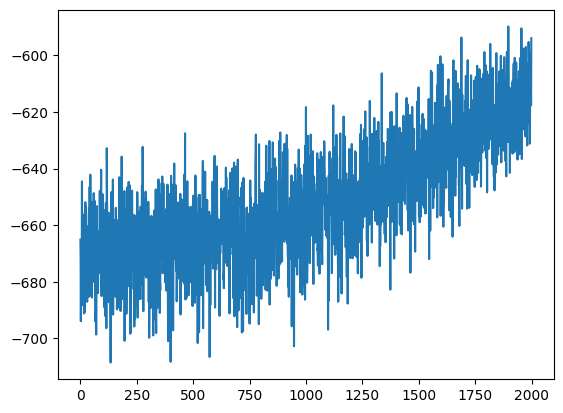

In [10]:
plt.plot(loss_primal);

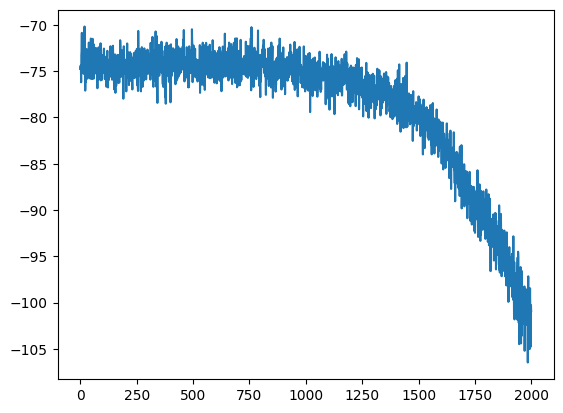

In [11]:
plt.plot(loss_dual);

# Linear rewards

In [8]:
ds = 4
da = 2

tau = 0.2

G1 = - torch.tensor([1.0, 1.0, .001, .001]).double()
G2 = - torch.tensor([.001, .001, 1.0, 1.0]).double()

R1 = - torch.tensor([0.01, 0.01]).double()
R2 = - torch.tensor([0.01, 0.01]).double()

def primal_reward_fn(env, a):
    return (env.s.abs() * G1).sum(dim=1) + (a.abs() * R1).sum(dim=1) - (tau / 2) * (a * a).sum(dim=1)

def dual_reward_fn(env, a):
    return ((env.s ** 2) * G2).sum(dim=1) + (tau / 2) + ((a ** 2) * R2).sum(dim=1)

def starting_pos_fn(nsamples):
        rng = np.random.default_rng()

        s = torch.tensor(rng.uniform(
            low=[-100, -100, -10, -10],
            high= [100, 100, 10, 10],
            size=[nsamples, 4],
        )).double()

        a = torch.tensor(rng.uniform(
            low=[-10, -10],
            high= [10, 10],
            size=[nsamples, 2],
        )).double()

        return s, a

In [35]:
epochs = 1000
n_pe = 100
n_rho = 1_000
n_roll = 400

gamma = 0.99
alpha = 1.0
eta = 0.0001

b = -800

env = RobotWorld(range_pos=[-100, 100], range_vel=[-.1, .1])
sampler = Sampler(env, gamma)
dpgpd = ADpgpdSampled(ds, da, env, eta, tau, gamma, b, alpha, primal_reward_fn, dual_reward_fn, starting_pos_fn)

K, losses_primal, losses_dual = dpgpd.train_unconstrained(epochs, n_pe, n_rho, n_roll)

KeyboardInterrupt: 

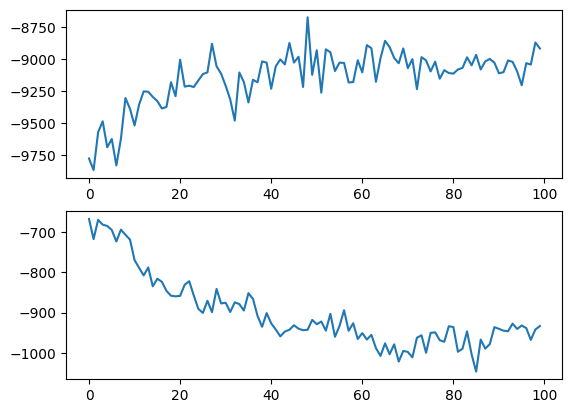

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=1)
axes = axes.flatten()
axes[0].plot(losses_primal)
axes[1].plot(losses_dual)
plt.show()

In [22]:
T = 10000
states, actions = sampler.sample_trajectory(K, T)
plt.figure(figsize=[4, 4])
plt.scatter(states[-1, 0], states[-1, 1], marker='*')
plt.plot(states[:, 0], states[:, 1])
plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.axis('off')
plt.show()

NameError: name 'sampler' is not defined

In [36]:
epochs = 10_000
n_pe = 100
n_rho = 20_000
n_roll = 400

gamma = 0.99
alpha = 1.0
eta = 0.00001

b = -800

env = RobotWorld(range_pos=[-100, 100], range_vel=[-.1, .1])
sampler = Sampler(env, gamma)
dpgpd = ADpgpdSampled(ds, da, env, eta, tau, gamma, b, alpha, primal_reward_fn, dual_reward_fn, starting_pos_fn)

K, lmbda, losses_primal, losses_dual = dpgpd.train_constrained(epochs, n_pe, n_rho, n_roll)

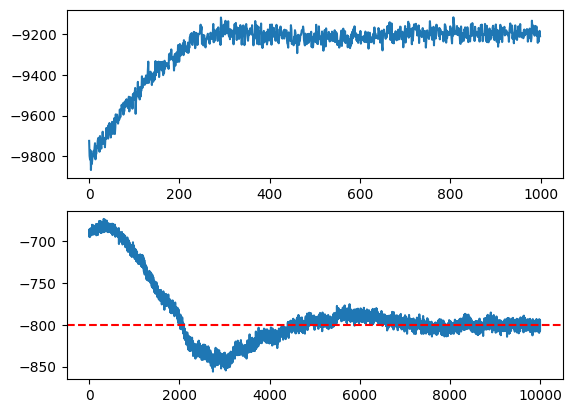

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=1)
axes = axes.flatten()
axes[0].plot(losses_primal)
axes[1].plot(losses_dual)
axes[1].axhline(y=b, color='r', linestyle='--')
plt.show()

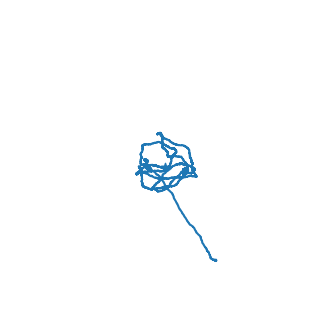

In [33]:
T = 10000
states, actions = sampler.sample_trajectory(K, T)
plt.figure(figsize=[4, 4])
plt.scatter(states[-1, 0], states[-1, 1], marker='*')
plt.plot(states[:, 0], states[:, 1])
plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.axis('off')
plt.show()

In [38]:
np.save('../results/vel_sampled_primal.npy', losses_primal)
np.save('../results/vel_sampled_dual.npy', losses_dual)

In [18]:
gamma = .99
b = -800

n_epochs = 10_000
n_episodes = 1
n_samples = 100
n_rollout = 400
n_rho = 2_000

num_features = 256
lr_actor = 1e-7
lr_critic = 1e-7
lr_dual = 1e-4

env = RobotWorld(range_pos=[-100, 100], range_vel=[-.1, .1])

nnpgpd = Nnpgpd(ds, da, env, num_features, lr_actor, lr_critic, lr_dual, gamma, b, starting_pos_fn, primal_reward_fn, dual_reward_fn)
loss_primal, loss_dual = nnpgpd.train(n_epochs, n_episodes, n_samples, n_rollout, n_rho)

Epoch 0 - Primal -9801.534517700962 - Dual -712.8242666791505 - Lambda 0.0
Epoch 10 - Primal -9582.929332499914 - Dual -739.1798223330288 - Lambda 0.0
Epoch 20 - Primal -9760.473782560855 - Dual -710.5384342604236 - Lambda 0.0
Epoch 30 - Primal -9784.889804282093 - Dual -708.8600996332236 - Lambda 0.0
Epoch 40 - Primal -9810.51025803072 - Dual -718.4492737763541 - Lambda 0.0
Epoch 50 - Primal -9676.356509894264 - Dual -716.627900144681 - Lambda 0.0
Epoch 60 - Primal -9539.881805019642 - Dual -711.6425484469543 - Lambda 0.0
Epoch 70 - Primal -9580.66412118287 - Dual -717.1354056317517 - Lambda 0.0
Epoch 80 - Primal -9601.09695791044 - Dual -724.6932198329898 - Lambda 0.0
Epoch 90 - Primal -9781.886874732 - Dual -712.0288435140562 - Lambda 0.0
Epoch 100 - Primal -9689.757092502623 - Dual -739.725333778454 - Lambda 0.0
Epoch 110 - Primal -9728.055288390979 - Dual -712.5377650027016 - Lambda 0.0
Epoch 120 - Primal -9657.657724031691 - Dual -721.7561514652523 - Lambda 0.0
Epoch 130 - Primal

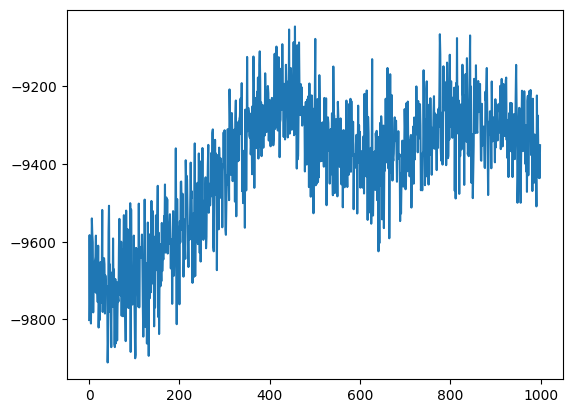

In [19]:
plt.plot(loss_primal);

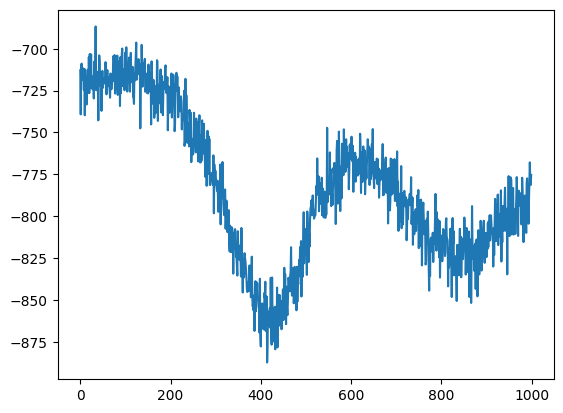

In [20]:
plt.plot(loss_dual);

In [21]:
np.save('../results/vel_sampled_primal_nn.npy', loss_primal)
np.save('../results/vel_sampled_dual_nn.npy', loss_dual)